In [2]:
import numpy as np, GPy, pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Trajectory Simulation

We simulate the number of data and some number of classes in a high number of dimensions

The classes are along a timeline from 0 to 10. Each class has a normal distribution around a random center point, where the variance is proportional to the size of the class

In [3]:
from cellSLAM.simulation import guo_simulation

Now we can use this latent trajectory in order to push it through a non linear mapping up into higher dimensions.
In order for all methods to be able to pick out the time information more easily we slightly hint at the time information by including its covariance in a non-linear manner and with a tenth of magnitude into the covariance structure we sample from.

The variance added now is technical variance, whereas the variance before was biological variance!

We choose a high technical variance in order to ensure a realistic experiment setting. 

We will also run several examples increasing the technical variance and see how the trajectory is recovered using different methods.

In [4]:
%run run_method_comparison.py

In [5]:
from scipy.stats import gaussian_kde
from scipy.spatial.distance import squareform, pdist

In [6]:
from __future__ import print_function

In [7]:
from cellSLAM.simulation.simulate_trajectory import make_cell_division_times, simulate_latent_space

In [16]:
from __future__ import print_function
d = np.linspace(0,1,100)
results = pd.DataFrame(index=pd.MultiIndex.from_product([seeds, range(10), d],names=['SLS','datasim','d']), columns=['distance'])
supp_dir = '../supplementary/simulations/'
for seed in seeds:
    print(seed, end=' ')
    for file in os.listdir(os.path.join(supp_dir, str(seed))):
        if file.endswith('.csv') and 'Xsim' not in file and 'wanderlust' not in file:
            data = pd.read_csv(os.path.join(supp_dir, str(seed), file), index_col=0)
            data, labels = data.ix[:, :-1], data['labels']
            seed, datasim = map(int, file.rstrip('.csv').split('_'))
            print(datasim, end=' ')
            sd = pdist(data.values.copy())**2
            sd /= sd.max()
            kde = gaussian_kde(sd)(d)
            results.loc[seed,datasim] = kde[:,None]

8971 7 9 3 2 6 4 0 8 5 1 3551 9 7 8 2 4 1 5 3 0 6 3279 1 5 3 2 0 9 8 7 4 6 5001 2 8 5 1 9 3 0 4 6 7 5081 3 2 8 7 5 1 4 6 9 0 

In [13]:
mguo = GPy.load('Guo/singlecellGuo.pickle')
mdeng = GPy.load('Deng/deng_model.pickle')
mtang = GPy.load('Tang/singlecellTang.pickle')

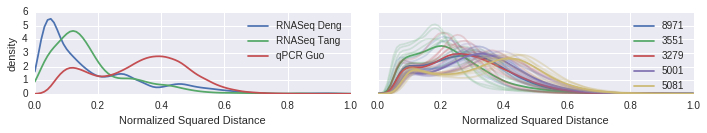

In [22]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,2), sharey=True)

sd = pdist(mdeng.Y)**2
sd /= sd.max()
#plt.hist(sd, bins=d, normed=True)
ax1.plot(d, gaussian_kde(sd)(d), label='RNASeq Deng')

sd = pdist(mtang.Y)**2
sd /= sd.max()
#plt.hist(sd, bins=d, normed=True)
ax1.plot(d, gaussian_kde(sd)(d), label='RNASeq Tang')

sd = pdist(mguo.Y)**2
sd /= sd.max()
#plt.hist(sd, bins=d, normed=True)
ax1.plot(d, gaussian_kde(sd)(d), label='qPCR Guo')
ax1.legend(loc='upper right')

sns.tsplot(data=results.reset_index(), time='d', value='distance', condition='SLS', 
           unit='datasim',err_style="unit_traces", ax=ax2, n_boot=10)

ax2.set_ylabel('')
ax1.set_ylabel('density')
ax1.set_xlabel('Normalized Squared Distance')
ax2.set_xlabel('Normalized Squared Distance')

ax2.legend(loc='upper right')

fig.tight_layout()
fig.savefig('../diagrams/simulation/squared_distances.pdf', transparent=True, bbox='tight')

# Save simulations to data

Save the simulations to supplementary materials for others to use.

In [8]:
# Save simulations:
create_and_save_simulations(guo_simulation, '../supplementary/simulations')

SLS8971...
 0 1 2 3 4 5 6 7 8 9
SLS3551...
 0 1 2 3 4 5 6 7 8 9
SLS3279...
 0 1 2 3 4 5 6 7 8 9
SLS5001...
 0 1 2 3 4 5 6 7 8 9
SLS5081...
 0 1 2 3 4 5 6 7 8 9


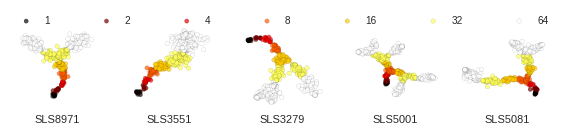

In [37]:
fig = plt.figure(figsize=(8,2), tight_layout=True)

gs = plt.GridSpec(6, 5)

axit = iter([fig.add_subplot(gs[1:, i]) for i in range(5)])

for seed in seeds:
    Xsim, simulate_new, t, c, labels, seed = guo_simulation(seed=seed)
    labs = np.array([l.split(' ')[0] for l in labels])
    ax = next(axit)

    prevlab = None
    for lab in labs:
        if lab != prevlab:
            color = plt.cm.hot(c[lab==labs])
            ax.scatter(*Xsim[lab==labs].T, c=color, alpha=.7, lw=.1, label=lab)
            prevlab = lab
        
    ax.set_xlabel("SLS{}".format(seed))
    ax.set_frame_on(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

leg_hand = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[0, :])
ax.legend(*leg_hand, ncol=7, mode='expand')
ax.set_frame_on(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig('../diagrams/simulation/simulated_latent_spaces.pdf', transparent=True, bbox='tight')

5001 5001


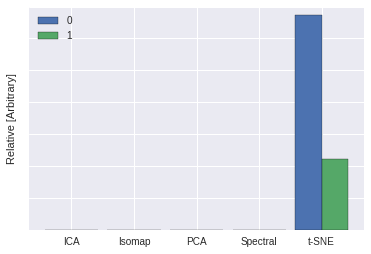

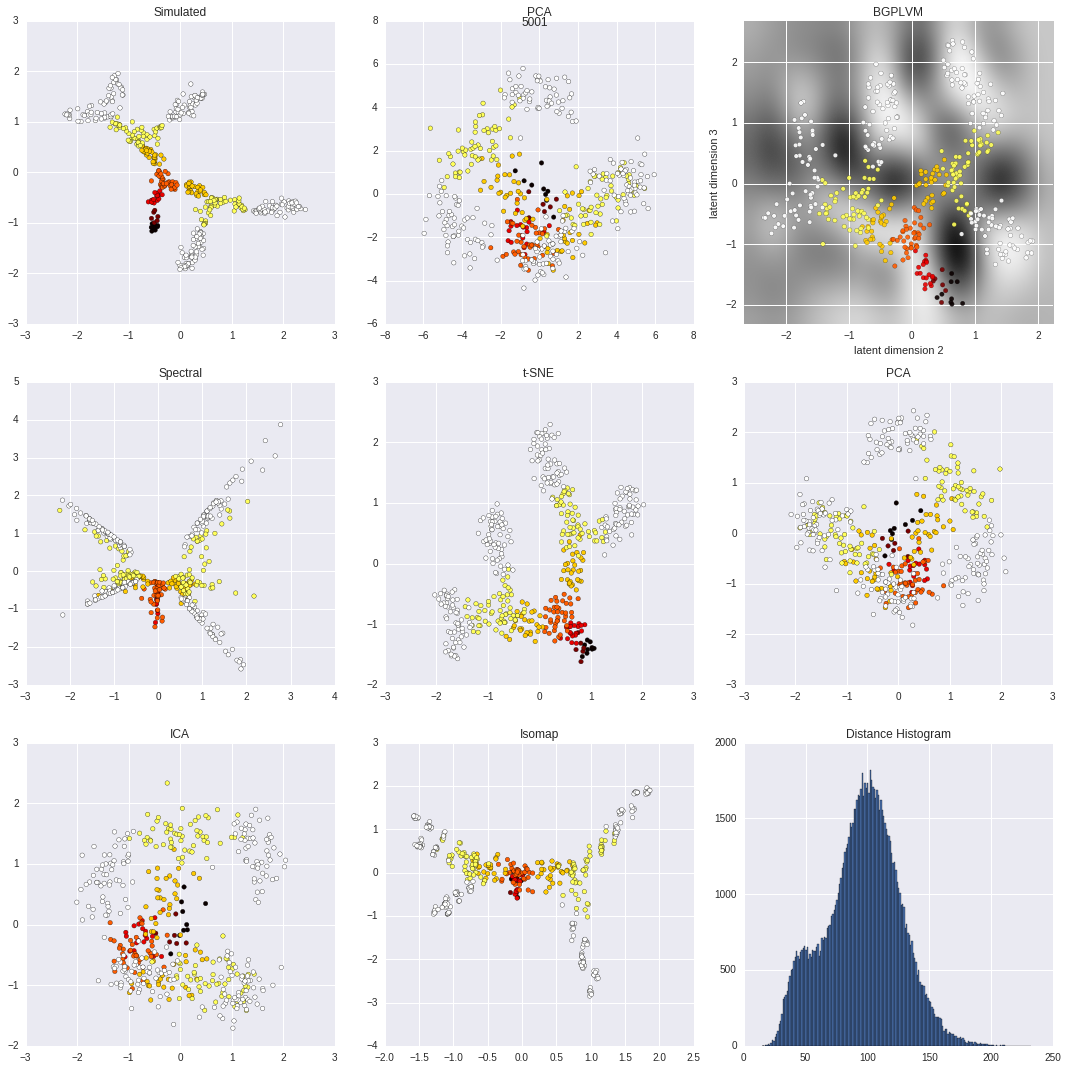

In [7]:
for seed in seeds[3:4]:
    print seed,
    Xsim, simulate_new, t, c, labels, seed = guo_simulation(seed=seed)

    Y = simulate_new()
    #plot_dist_hist(Y)
    X_init = run_methods(Y, methods, None, None)
    m = GPy.models.BayesianGPLVM(Y, 10, X=X_init, num_inducing=25)
    m.optimize(max_iters=1000)

    fig, ax = plt.subplots(figsize=(6,4))
    tmp = pd.DataFrame(m.kern.input_sensitivity()[None,:], columns=pd.MultiIndex.from_product((methods.keys(), range(2))))
    tmp.stack(level=0).loc[0].plot(kind='bar', width=.85, ax=ax, rot=0)
    _ = ax.yaxis.set_ticklabels([])
    ax.set_ylabel('Relative [Arbitrary]')

    plot_comparison(Xsim, X_init, Y, c, m)
    plt.suptitle(seed)
    plt.tight_layout()
    print seed

In [5]:
plt.close('all')

In [6]:
seed = 5001
y_seed = 5

In [ ]:
Xsim, simulate_new, t, c, labels, seed = guo_simulation(seed=seed)

np.random.seed(y_seed)
Y = simulate_new()

begin = 0

In [23]:
labels = np.array(labels)
ulabels = np.unique(labels)

In [20]:
from cellSLAM.simulation import run_methods

In [21]:
#plot_dist_hist(Y)
X_init, dims = run_methods(Y, methods)

In [12]:
m = GPy.models.BayesianGPLVM(Y, 10, X=X_init, num_inducing=40)

In [13]:
m.kern.lengthscale.fix()
m.likelihood.fix(.1)
m.X.variance = .01
m.optimize(max_iters=600, messages=True, clear_after_finish=True)
m.unfix()
m.optimize(max_iters=5e4, messages=True, clear_after_finish=0)

5001


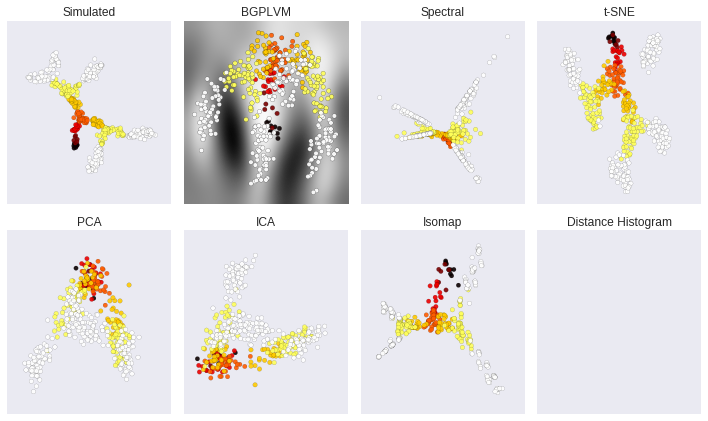

In [29]:
fig, axes = plt.subplots(2,4,figsize=(10,6))
axit = axes.flat
cols = plt.cm.hot(c)

ax = next(axit)
ax.scatter(*Xsim.T, c=cols, cmap='hot', lw=.1)
ax.set_title('Simulated')
ax.set_xticks([])
ax.set_yticks([])

ax = next(axit)
msi = m.get_most_significant_input_dimensions()[:2]
#ax.scatter(*m.X.mean.values[:,msi].T, c=t, cmap='hot')
#m.plot_inducing(ax=ax, color='w')
m.plot_magnification(resolution=20, scatter_kwargs=dict(color=cols, cmap='hot', s=20), marker='o', ax=ax)
ax.set_title('BGPLVM')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])

i = 0
for name in methods:
    ax = next(axit)
    ax.scatter(*X_init[:,i:i+2].T, c=cols, cmap='hot', lw=.1)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 2

ax = next(axit)
#plot_dist_hist(Y, ax)
ax.set_title('Distance Histogram')
ax.set_xticks([])
ax.set_yticks([])


plt.tight_layout()
print seed
#plt.savefig('../diagrams/simulation/{}_comparison.pdf'.format(seed), transparent=True, bbox_inches='tight')

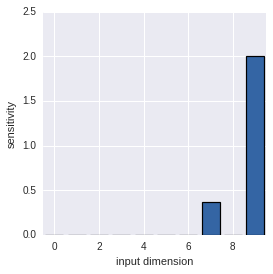

In [18]:
fig, ax = plt.subplots(figsize=(4,4))

m.kern.plot_ARD(ax=ax)

fig.savefig('../diagrams/simulation/BGPLVM_ARD_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

In [14]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import lil_matrix, find
import networkx as nx, itertools

In [26]:
from manifold import ManifoldCorrectionTree, ManifoldCorrectionKNN
mc = ManifoldCorrectionTree(m)

msi = m.get_most_significant_input_dimensions()[:2]
Xmc = m.X.mean[:,msi]
posmc = dict((i, Xmc[i]) for i in range(Xmc.shape[0]))

In [16]:
from cellSLAM import waddington_landscape
res = 50
Xgrid, wad, X, wadX = waddington_landscape(m, resolution=res)
r = lambda x: x.reshape(res, res).T

In [15]:
%run plot_definitions_datasets.py

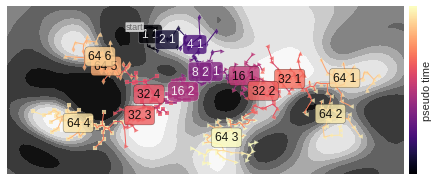

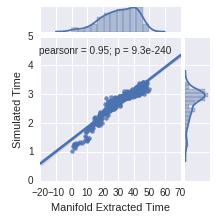

In [23]:
pt = mc.distances_along_graph
pseudo_time = pt[begin]
pt_graph = mc.get_time_graph(begin)
G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(8,3))

#m.plot_magnification(ax=ax, plot_scatter=False)

CS = ax.contourf(r(Xgrid[:,0]), r(Xgrid[:,1]), r(wad), linewidths=.6)
plot_time_graph(G, X, pseudo_time, labels, ulabels, begin, (-30, 10), fig, ax)
mi, ma = Xgrid.min(0), Xgrid.max(0)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])

fig.savefig('../diagrams/simulation/BGPLVMtree_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

gs = plt.GridSpec(10,5)

ax = sns.jointplot(pseudo_time, t[:,0], kind="reg", size=3, )
ax.ax_joint.set_xlabel('Manifold Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
ax.ax_joint.figure.savefig('../diagrams/simulation/BGPLVM_time_scatter_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

In [31]:
msi = m.get_most_significant_input_dimensions()[:2]
X = m.X.mean[:,msi]

mc = ManifoldCorrectionKNN(m, 3)
pt = mc.distances_along_graph
pseudo_time = pt[begin]
pt_graph = mc.get_time_graph(begin)
G = nx.Graph(pt_graph)

fig, ax = plt.subplots(figsize=(8,3))

#m.plot_magnification(ax=ax, plot_scatter=False)

CS = ax.contourf(r(Xgrid[:,0]), r(Xgrid[:,1]), r(wad), linewidths=.6)
plot_time_graph(G, X, pseudo_time, labels, ulabels, begin, (-30, 10), fig, ax)
mi, ma = Xgrid.min(0), Xgrid.max(0)
ax.set_xlim(mi[0], ma[0])
ax.set_ylim(mi[1], ma[1])

fig.savefig('../diagrams/simulation/BGPLVMknn_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pseudo_time, t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('BGPLVM Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
ax.ax_joint.figure.savefig('../diagrams/simulation/BGPLVM_knn_time_scatter_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

NameError: name 'm' is not defined

In [31]:
i = 0
for method in methods:
    print method, '{}:{}'.format(i,i+2)
    i+=2

Spectral 0:2
t-SNE 2:4
PCA 4:6
ICA 6:8
Isomap 8:10


In [16]:
from cellSLAM.simulation.graph_extraction import extract_manifold_distances_mst, extract_manifold_distances_knn, extract_distance_graph


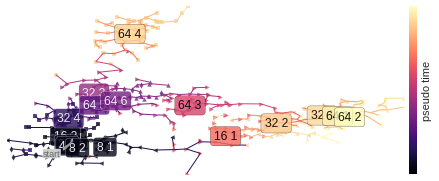

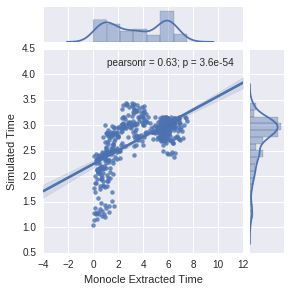

In [29]:
# Monocle:

X = X_init[:, dims['ICA']].copy()

D, mst = extract_manifold_distances_mst(squareform(pdist(X)))
G = nx.Graph(extract_distance_graph(D, mst, begin))

pseudo_time = D[begin]

fig, ax = plt.subplots(figsize=(8,3))

plot_time_graph(G, X, pseudo_time, labels, ulabels, begin, (-30, -20), fig, ax)

fig.savefig('../diagrams/simulation/Monocle_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pseudo_time, t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('Monocle Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
ax.ax_joint.figure.savefig('../diagrams/simulation/Monocle_time_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

In [20]:
from scipy.sparse import lil_matrix, find

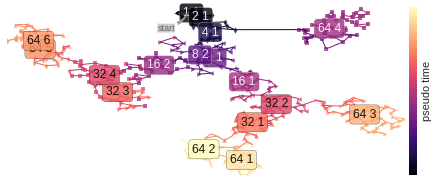

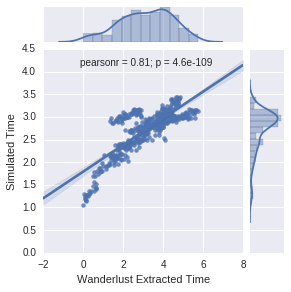

In [32]:
# Wanderlust (without smoothing)

X = X_init[:, dims['t-SNE']].copy()

pD = squareform(pdist(X))
Dmst, mst = extract_manifold_distances_mst(pD)
D, knn = next(extract_manifold_distances_knn(pD, [3], mst))

G = nx.Graph(extract_distance_graph(D, knn, begin))

pseudo_time = D[begin]

fig, ax = plt.subplots(figsize=(8,3))

plot_time_graph(G, X, pseudo_time, labels, ulabels, begin, (-30, -20), fig, ax)

fig.savefig('../diagrams/simulation/Wanderlust_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')

ax = sns.jointplot(pseudo_time, t[:,0], kind="reg", size=4)
ax.ax_joint.set_xlabel('Wanderlust Extracted Time')
ax.ax_joint.set_ylabel('Simulated Time')
ax.ax_joint.figure.savefig('../diagrams/simulation/Wanderlust_time_{}_{}.pdf'.format(seed, y_seed), transparent=True, bbox_inches='tight')